In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import time
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential,load_model
from keras.utils import to_categorical
from tensorflow import keras

In [4]:
data_path = '/content/drive/My Drive/dorwiness_dataset/aditya/d3/train/'
img_data_list = []
labels = []
CATEGORIES=["Open_Eyes","Closed_Eyes"]
def read_data():
  for dataset in CATEGORIES:
    path=os.path.join(data_path,dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    class_num=CATEGORIES.index(dataset)
    for img in os.listdir(path):
      input_img=cv2.imread(os.path.join(path,img))
      input_img = cv2.cvtColor(input_img,cv2.COLOR_RGBA2GRAY)
      input_img=cv2.resize(input_img,(224,224))
      input_img=cv2.merge([input_img,input_img,input_img])
      img_data_list.append(input_img)
      labels.append(class_num)
  img_data = np.array(img_data_list)
  return img_data, labels

X,Y=read_data()

Loaded the images of dataset-Open_Eyes

Loaded the images of dataset-Closed_Eyes



In [5]:
img_x=np.array(X)
img_x = img_x.astype('float32')
img_x = img_x/255
img_x.shape

(4000, 224, 224, 3)

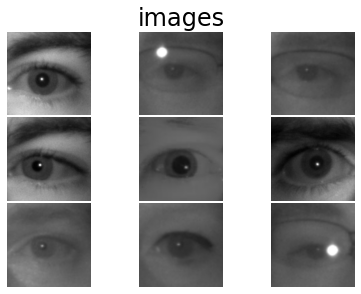

In [8]:
import matplotlib.pyplot as plt
def plot_images(images, title):
    nrows, ncols = 3, 3
    figsize = [15, 15]

    fig, ax = plt.subplots(nrows=3, ncols=3)

    for i, axi in enumerate(ax.flat):
        axi.imshow(X[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(X, 'images')

In [9]:
labels=np.array(Y)
num_classes=2
labels =to_categorical(labels, num_classes)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(img_x, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    stratify=np.array(labels), 
                                                    )
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_CHANNELS=3
input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS)
x_train=x_train.reshape(x_train.shape[0],IMAGE_WIDTH,IMAGE_HEIGHT,3)
x_test=x_test.reshape(x_test.shape[0],IMAGE_WIDTH,IMAGE_HEIGHT,3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 2)                 23591810  
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________
None


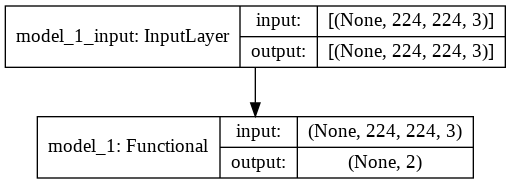

In [14]:
from keras.applications import ResNet50
from keras.utils import plot_model
resnet = ResNet50(include_top=True, weights='imagenet')
out = Dense(2, activation='softmax', name='predictions')(resnet.layers[-2].output)
resnet_model = Model(resnet.input, out)

for layer in resnet_model.layers:
  layer.trainable = True

model = Sequential()
model.add(resnet_model)
model.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

plot_model( model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)  

In [15]:
def step_decay(epoch):
  initial_rate = 1e-3
  factor = int(epoch / 10)
  lr = initial_rate / (10 ** factor)
  return lr

In [16]:
model_dir='/content/drive/My Drive/dorwiness_dataset/vishwajeet_model/'

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
epochs_to_wait_for_improve=3
model_name = 'resnet_eyes'
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint(model_dir + model_name+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
lr_schedule = LearningRateScheduler(step_decay)
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test),callbacks=[early_stopping_callback,checkpoint_callback, lr_schedule])

Epoch 1/30
100/100 [==============================] - 36s 363ms/step - loss: 1.1658e-05 - accuracy: 1.0000 - val_loss: 2.0026e-05 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00002, saving model to /content/drive/My Drive/dorwiness_dataset/vishwajeet_model/resnet_eyes.h5
Epoch 2/30
100/100 [==============================] - 36s 362ms/step - loss: 7.0670e-06 - accuracy: 1.0000 - val_loss: 1.6601e-05 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.00002 to 0.00002, saving model to /content/drive/My Drive/dorwiness_dataset/vishwajeet_model/resnet_eyes.h5
Epoch 3/30
100/100 [==============================] - 36s 362ms/step - loss: 9.8568e-06 - accuracy: 1.0000 - val_loss: 1.4537e-05 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.00002 to 0.00001, saving model to /content/drive/My Drive/dorwiness_dataset/vishwajeet_model/resnet_eyes.h5
Epoch 4/30
100/100 [==============================] - 36s 362ms/step - loss: 5.7941e-06 - accuracy: 1.00

In [25]:
from sklearn.metrics import roc_auc_score, accuracy_score
preds = model.predict(x_test)
y_test_new = np.argmax(y_test, axis=1)
pred_l = np.argmax(preds, axis=1)
print('Test AUROC:', roc_auc_score(y_test, preds))
print('Test acc:', accuracy_score(y_test_new, pred_l))

Test AUROC: 1.0
Test acc: 1.0


In [26]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
conf = confusion_matrix(y_test_new, pred_l)
print(conf)
print('----------------------------------------------------')
print(classification_report(y_test_new, pred_l))
print('----------------------------------------------------')

Confusion Matrix
[[400   0]
 [  0 400]]
----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

----------------------------------------------------
